In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.search_factory import SearchFactory
from lib.model.search.beam_search_k_finder import BeamSearchKFinder, random_samples

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample, display_table
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

from lib.model.inspector.prediction_inspector_factory import PredictionInspectorFactory

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/adrian/anaconda3/envs/image-captioning/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Image captioning model

## Common parameters

What dataset we are going to use?

In [3]:
dataset_name='8k' # Flickr8k
# dataset_name='30k' # Flickr30k

Each line of dataset contain an image_path + separator + a descrption. Next regex are used to separate these:

In [4]:
line_separator = { 
    '8k': r'#[0-9]', # Flickr8k
    '30k': r'\| [0-9]\|' # Flickr30k
}

Dataset data file & iamges paths:

In [5]:
dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

What word embedding we are going to use?

In [6]:
# embeding_name = 'glove.6B.300d'
embeding_name = 'glove.840B.300d'

word_embedding_path = f'./dataset/{embeding_name}.txt'

Embedding word vector size: This depend of embedding file, ins this case is 300.

In [7]:
embedding_vector_dim = 300

Path's where we save images and words embeddings:

In [8]:
image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

Path where save model weights:

In [9]:
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{loss:.4f}_val_loss_{val_loss:.4f}__rmse_{rmse:.4f}__val_rmse_{val_rmse:.4f}.h5'

## Data preparation

Load dataset:

In [10]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [11]:
dataset.max_desc_len()

174

Separate sample in three groups:
* Train samples
* Validatiion samples
* Test sasmples

In [14]:
test_size=0.1
test_size=0.124

In [15]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=test_size, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=test_size, shuffle=True)

Save sample groups. This step is very important, given that once model was train always must evaluate with same test samples selected before model train. 

In [16]:
save_obj(f'{dataset_path}/train_samples', train_samples)
save_obj(f'{dataset_path}/val_samples', val_samples)
save_obj(f'{dataset_path}/test_samples', test_samples)

Load samples groups:

In [17]:
train_samples = load_obj(f'{dataset_path}/train_samples')
val_samples = load_obj(f'{dataset_path}/val_samples')
test_samples = load_obj(f'{dataset_path}/test_samples')

In [18]:
print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 7087, Val: 879, Test: 125


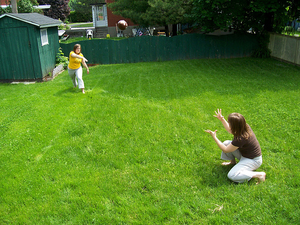

In [19]:
show_sample(train_samples[0])

### Generate images embedding 
This step evaluate all dataset images in **InceptionV3 model** with **imagenet weights** and get output from last convolutional layer. 
The idea is precalculate an "image embedding" to minimize the **image captionining model** train times. Save results to a file given that this process can take a long time.

In [20]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)
else:
    image_features = load_obj(image_features_path)

print(f'Image embedding size: {len(image_features)} == Dataset size: {len(dataset.samples())}')
print(f'\nSample:\n- Image: {image_features[0][0]}\n- Embedding vector: {image_features[0][1]}')
image_features = dict(image_features)

Image embedding size: 8091 == Dataset size: 8091

Sample:
- Image: ./dataset/8k/images/1305564994_00513f9a5b.jpg
- Embedding vector: [ 0.06508786  0.03218709  0.0237698  ...,  0.3836866   0.19910577
  0.23510413]


### Generate words embedding

Select words vocabulary:

In [21]:
word_min_occurs=10

vocabulary = dataset.words_set(min_occurs=word_min_occurs)

vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())

In [22]:
print(f'Words(occurs>={word_min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


Build **world to index*** and **index to world** dictionaries:

In [23]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

Build world embedding matrix: Save matrix to a file given that this process can take a long time.

In [24]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)    
    embedding_matrix = embedding_generator.generate(word_to_index)
    save_obj(descrption_embedding_path, embedding_matrix)
else:
    embedding_matrix = load_obj(descrption_embedding_path)

print(f'Word embedding size: {len(embedding_matrix)}') 

Word embedding size: 1593


**Note**: In best case word embedding size is equal to vocabulary size. 

## Model build & train

In [25]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(1024)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(1024)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(1024)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

### Train model

Define hiperparameters uses to train each train step:

In [36]:
class Hiperparams:
    def __init__(self, **kwargs): self.__dict__ = kwargs

step_train_params = [
    Hiperparams(
        step = 1,
        epochs = 8,
        lr = 0.001,
        batch_size = 4,
        factor = 0.2,
        patience=1,
        # weights_file = None,
        weights_file = f'{weights_path}/weights__epoch_09__loss_2.3296_eval_loss_2.9791__rmse_0.0212__val_rmse_0.0220.h5'
    )
#    ,
#    Hiperparams(
#        step = 2,
#        epochs = 4,
#        lr = 0.00004,
#        batch_size = 10,
#        factor = 0.2,
#        patience = 1,
#        weights_file = None
#    )
]

Builder data generators uses to generate train bacth and evalidation sets:

In [37]:
def build_train_val_data_generators(params):
    train_generator = DataGenerator(
        train_samples,
        image_features,
        word_to_index,
        index_to_word,
        dataset.max_desc_len(), 
        vocabulary_size,
        batch_size=params.batch_size
    )
    val_generator = DataGenerator(
        val_samples,
        image_features,
        word_to_index,
        index_to_word,
        dataset.max_desc_len(), 
        vocabulary_size,
        batch_size=params.batch_size
    )
    return train_generator, val_generator

Build callbacks used to train model:
* ModelCheckpoint: Save model weights after each epoch.
* AdamLearningRateTracker: Show lerning rate.
* ReduceLROnPlateau: Use to avoid vanishing gradient.
* MetricsPlotter: Plot metrics.

In [38]:
def build_callbacks(val_generator, params):
    return [
        ModelCheckpoint(
            weights_file_path_patern,
            monitor='val_loss', 
            verbose=1,
            save_best_only=True, 
            save_weights_only=True, 
            mode='auto',
            period=1
        ),
        AdamLearningRateTracker(evaluate_interval=105),
        ReduceLROnPlateau(
            monitor  = 'val_loss',
            factor   = params.factor,
            patience = params.patience
        ),
        MetricsPlotter(
            val_generator, 
            plot_interval=100, 
            evaluate_interval=100, 
            batch_size=params.batch_size
        )
    ]

Train in model:



Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 174, 300)     477900      Description_Sequence[0][0]       
_________________________________________________________________________________

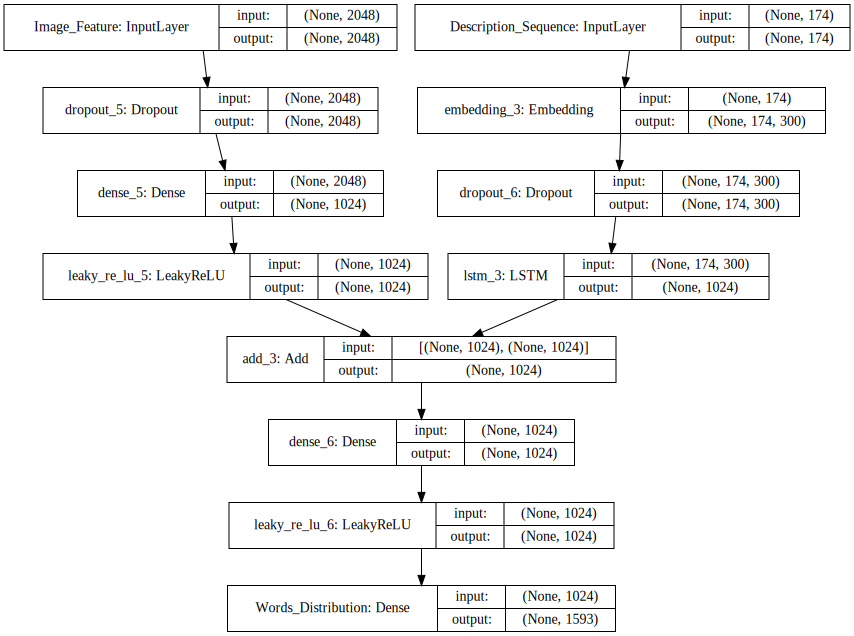

Load weights from weights/8k/weights__epoch_09__loss_2.3296_eval_loss_2.9791__rmse_0.0212__val_rmse_0.0220.h5


In [39]:
for params in step_train_params:
    train_generator, val_generator = build_train_val_data_generators(params)
    callbacks = build_callbacks(val_generator, params)
    
    model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=params.lr))
    model.show()

    if not params.weights_file is None:
        model.load(params.weights_file)
        
    steps_per_epoch=len(train_samples)/params.batch_size

    # model.fit(train_generator, val_generator, epochs=params.epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)    

## Best model output selection

We goning to use **beam search algorith** to try to improve model results selction a mode result from k prediction over the same input sample.

First of all we nett to found K value that improve model results: 

In [40]:
search_k_finder = BeamSearchKFinder(
    model=model,
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    image_features=image_features,
    descriptions=dataset.descriptions(),
    max_seq_len=dataset.max_desc_len()
)

In [41]:
random_test_samples = random_samples(test_samples, 60)
k_values=range(1, 10 + 1)

In [42]:
metrics = search_k_finder.find(samples=random_test_samples, k_values=k_values)

K: 1, Mean WMDSim: 0.5951949640318891, Time: 0:00:54.462552
K: 2, Mean WMDSim: 0.6010348074913101, Time: 0:01:26.783314
K: 3, Mean WMDSim: 0.6006584213903018, Time: 0:02:01.856549
K: 4, Mean WMDSim: 0.5988751440800224, Time: 0:02:12.373274
K: 5, Mean WMDSim: 0.5996647985262167, Time: 0:02:43.128947
K: 6, Mean WMDSim: 0.6045607502927144, Time: 0:03:35.004292
K: 7, Mean WMDSim: 0.6055244081186693, Time: 0:03:49.403086
K: 8, Mean WMDSim: 0.6032133262677154, Time: 0:04:15.744896
K: 9, Mean WMDSim: 0.6049583748944849, Time: 0:04:59.237884
K: 10, Mean WMDSim: 0.6060344434948951, Time: 0:05:28.494042


In [43]:
metrics.save()

Best K: 10



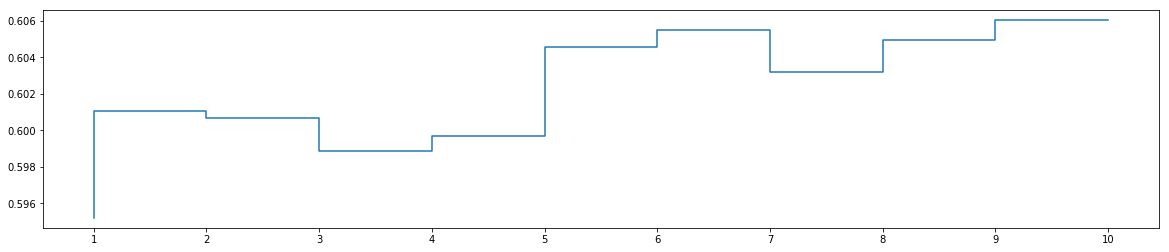

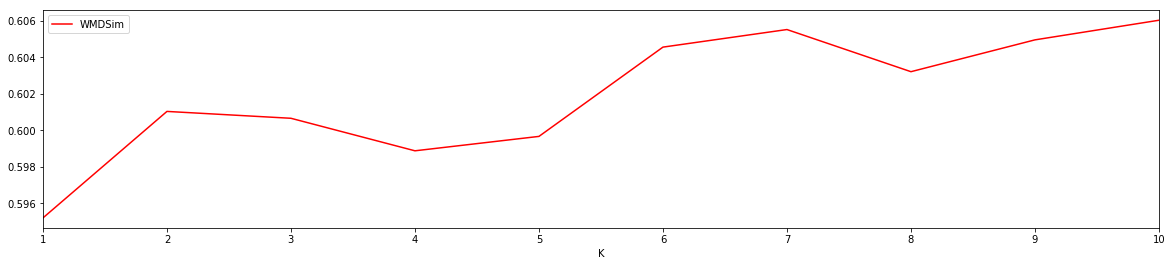

In [44]:
metrics.load()
metrics.show()

## Test model

In [62]:
class TestInspector:
    def __init__(self, k_values):
        self.inspectors = [(k, self.__create_inspector(k=k)) for k in k_values]

    def __create_inspector(self, k):
        return PredictionInspectorFactory.create_inspector(
            model,
            word_to_index,
            index_to_word,
            image_features,
            dataset.descriptions(),
            dataset.max_desc_len(),
            k,
            verbose=False
        )

    def inpect(self, sample):
        for k, inspector in self.inspectors:
            print(f'K={k}')
            inspector.inspect(sample)
        

K=7


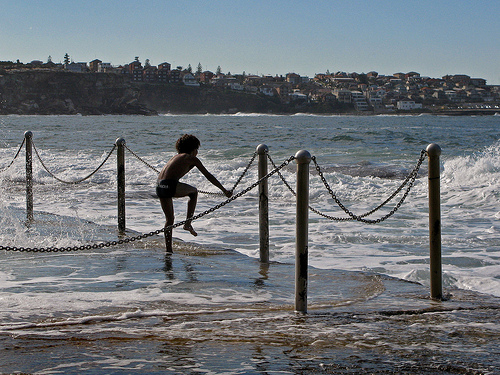

K=7


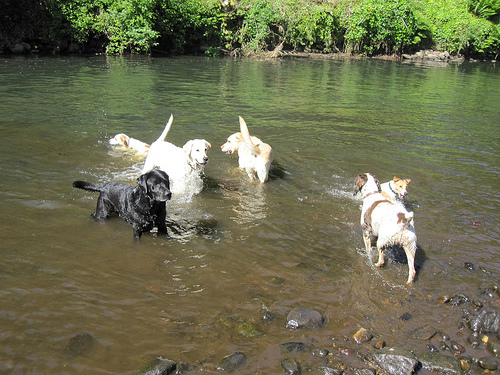

K=7


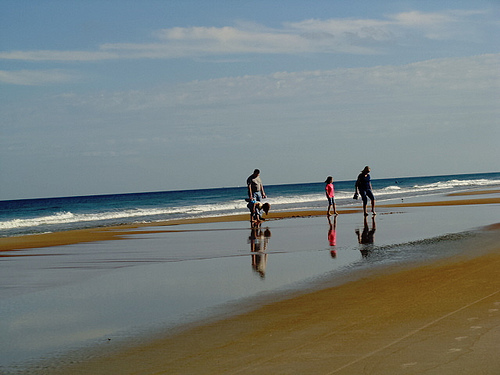

K=7


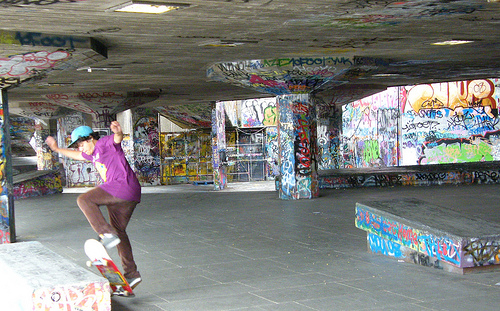

K=7


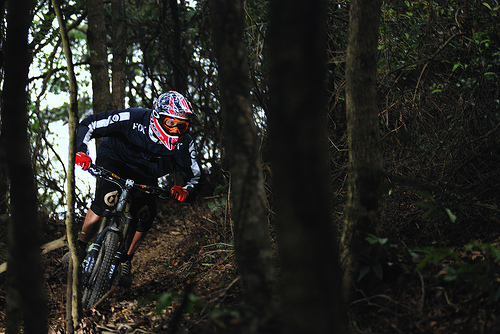

K=7


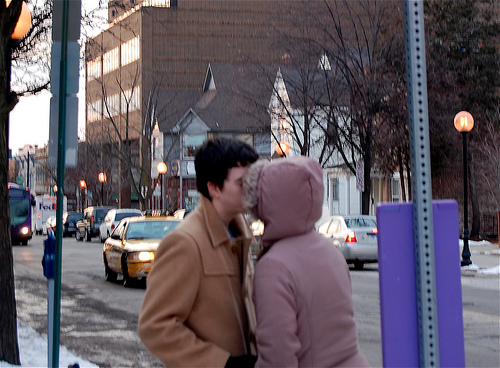

K=7


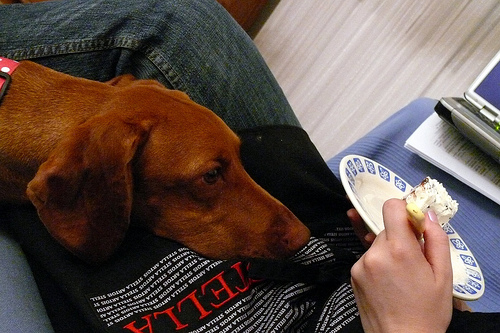

K=7


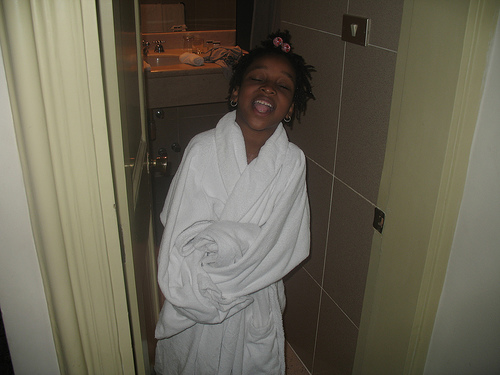

K=7


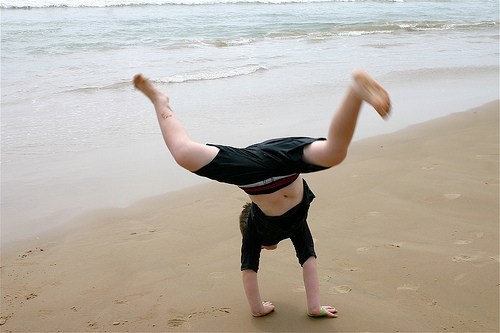

K=7


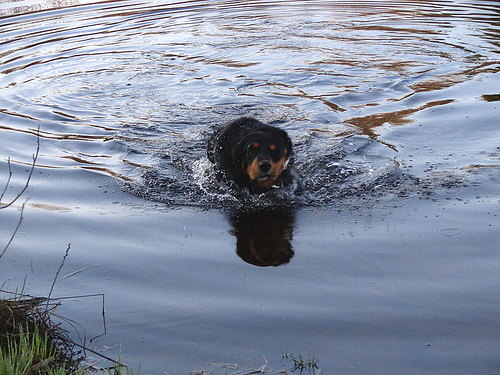

In [69]:
test_inspector = TestInspector(k_values=[7])
for sample in random_samples(test_samples, 10):
    test_inspector.inpect(sample)